In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.stats import norm

%matplotlib inline

import candel

SPEED_OF_LIGHT = candel.SPEED_OF_LIGHT

def r2cz(r, H0):
    return r * H0

%load_ext autoreload
%autoreload 2

In [2]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
config = candel.load_config(config_path)

reconstruction = "Carrick2015"
nsim = 0

loader = candel.field.name2field_loader(reconstruction)(
    nsim=nsim, **config["io"]["reconstruction_main"][reconstruction])


2025-08-19 23:15:01 replacing prior of `beta` with a delta function.


In [80]:
r = np.linspace(1e-5, 200, 500)

gen = np.random.default_rng(42)

npoints = 50000

RA = gen.uniform(0, 360, size=npoints)
dec = np.arcsin(gen.uniform(-1, 1, size=npoints)) * 180 / np.pi




def relax_to_one(los_density: np.ndarray,
                 r: np.ndarray,
                 r0: float,
                 ell: float,
                 out: np.ndarray | None = None) -> np.ndarray:
    """
    los_density: (num_los, num_radial)
    r: (num_radial,)
    For r > r0, blend los_density toward 1 with exp scale 'ell'.
    """
    if ell <= 0:
        raise ValueError("ell must be > 0")
    if r.ndim != 1 or los_density.ndim != 2 or los_density.shape[1] != r.size:
        raise ValueError("Shapes must be (L, N) and (N,)")

    mask = r > r0
    if out is None:
        out = los_density.copy()
    else:
        np.copyto(out, los_density)

    if mask.any():
        w = np.exp(-(r[mask] - r0) / ell)  # weight for original
        out[:, mask] = los_density[:, mask] * w + (1.0 - w)
    return out

In [ ]:
los_density, los_velocity = candel.field.interpolate_los_density_velocity(  # noqa
    loader, r, RA, dec, verbose=False)

los_velocity *= 0.43

los_density = relax_to_one(los_density, r, r0=100, ell=5)

In [102]:
cz_lim = 3000

H0 = 75
sigma_v = 250


def prior_r(r, rho):
    pi_r = rho * r**2
    pi_r /= simpson(pi_r, x=r)

    return pi_r


def p_det(H0, r_grid, rho_grid, vel_grid, make_plot=False):
    cz_pred = (1 + r2cz(r_grid, H0) / SPEED_OF_LIGHT) * (1 + vel_grid / SPEED_OF_LIGHT) - 1
    cz_pred *= SPEED_OF_LIGHT

    # intg = norm().cdf((cz_lim - cz_pred) / sigma_v ) * prior_r(r_grid, rho_grid)
    intg = (1 - norm().cdf((cz_lim - cz_pred) / sigma_v )) * prior_r(r_grid, rho_grid)

    if make_plot:
        plt.figure()
        plt.plot(r_grid, intg)
        plt.xlabel("r [Mpc/h]")
        plt.ylabel("p_det")
        plt.show()


    return simpson(intg, x=r)



In [103]:
N = len(los_density)
# N = 5

y = np.asarray([p_det(H0, r, los_density[i], los_velocity[i], make_plot=False) for i in range(N)])

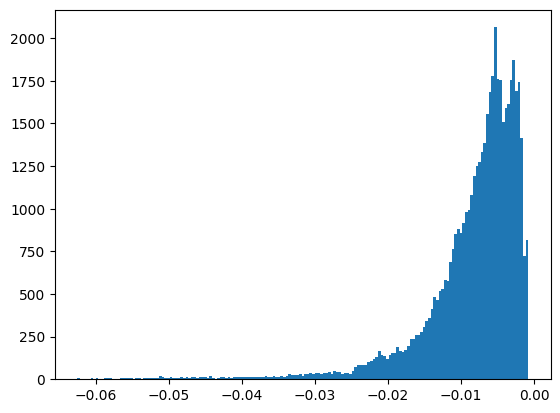

In [105]:
plt.figure()
plt.hist(np.log(y), bins="auto")
plt.show()

In [100]:
nrepeat = 1000

yprod = np.zeros(nrepeat)

for i in range(nrepeat):
    ks = np.random.choice(len(y), 5_00, replace=False)
    yprod[i] = np.log(y[ks]).sum()

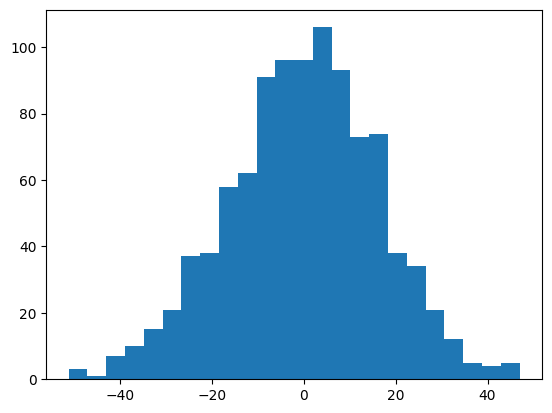

In [101]:
plt.figure()
plt.hist(yprod - yprod.mean(), bins="auto")

plt.show()

In [70]:
yprod

array([-506.40634791, -507.38850584, -499.36092808, -520.88274695,
       -501.47504503, -510.00625144, -517.49307439, -519.37990222,
       -498.10775434, -506.81953728, -509.92093106, -516.40327355,
       -514.00171993, -503.18112394, -504.94323658, -520.28839416,
       -516.29097773, -512.76820466, -508.79733947, -513.2972578 ,
       -514.20106502, -494.39423215, -512.39266918, -499.33289073,
       -507.91434609, -490.33604199, -520.03819861, -499.15717197,
       -513.84703604, -505.55831479, -509.76117079, -503.24926888,
       -511.51438487, -513.72723157, -505.16299357, -495.35176172,
       -524.54608768, -498.91518142, -503.61219975, -501.51892902,
       -507.4961267 , -495.20774908, -498.32537822, -504.19785396,
       -508.50786392, -489.3219193 , -501.41461012, -506.41069042,
       -513.07901189, -512.72862521, -496.39017912, -505.28015817,
       -501.65385767, -500.32407735, -503.9645587 , -510.21728526,
       -500.82976051, -495.89803226, -502.50008234, -505.57442

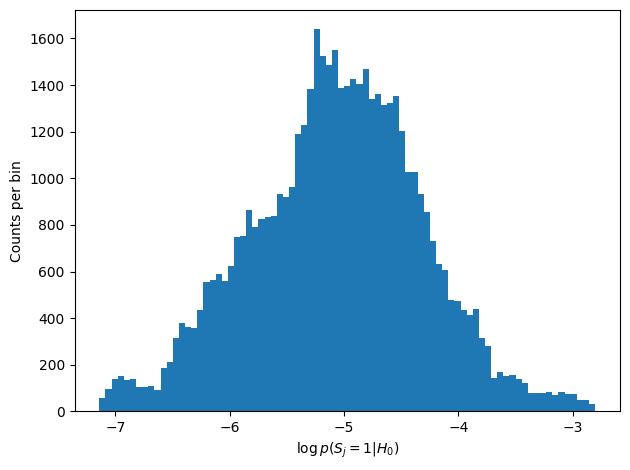

In [84]:
plt.figure()
plt.hist(np.log(y), bins="auto")

plt.xlabel(r"$\log p(S_j = 1 | H_0)$")
plt.ylabel("Counts per bin")

plt.tight_layout()
# plt.savefig("/Users/rstiskalek/Downloads/no_selection_universality.png", dpi=450)

plt.show()

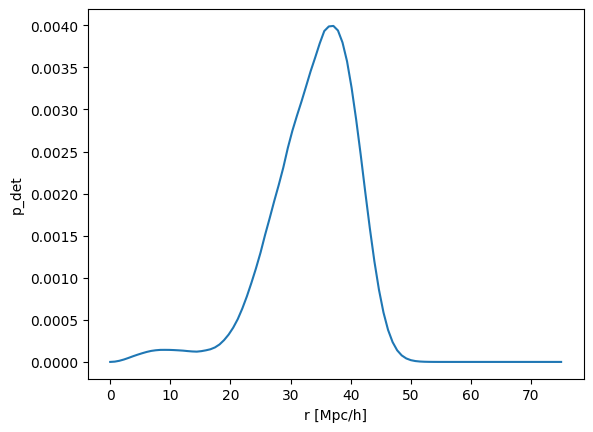

0 0.06285952682008453


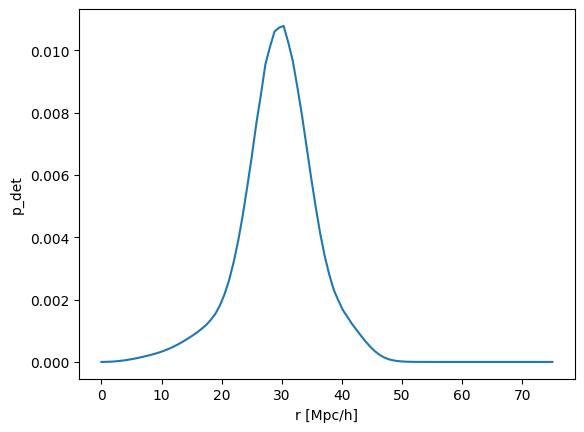

1 0.14217781969263835


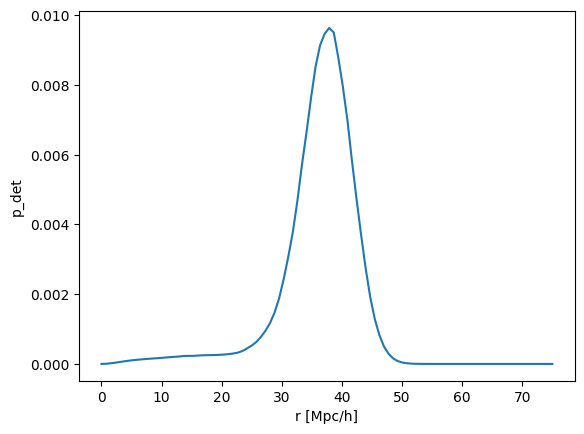

2 0.10578689653459783


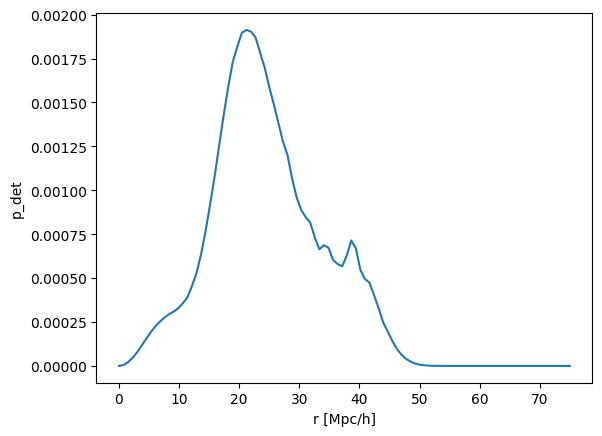

3 0.03594483234905144


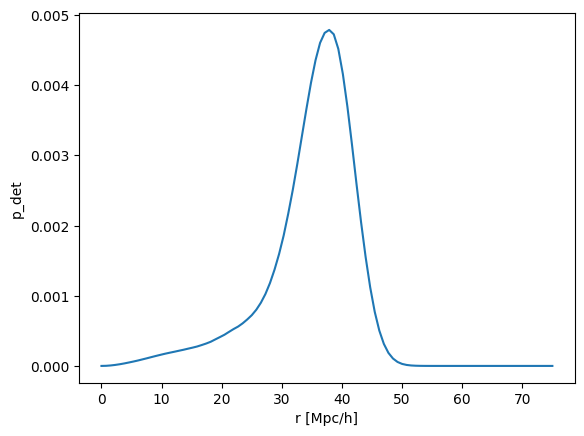

4 0.06344581646408202


In [34]:
for i in range(5):
    z = p_det(H0, r, los_density[i], make_plot=True)
    print(i, z)


In [26]:
p_det(H0, r, los_density[0], make_plot=False)

0.039549114909251754

In [54]:
rho_grid

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
def r2cz(r, H0):
    return r * H0


Rmax = 100
cz_lim = 3000

H0 = 75
sigma_v = 250


r = np.linspace(0, Rmax, 1000)

rho_A = np.sin(r / 5)**2
rho_B = np.cos(r / 5)**2

def prior_r(r, rho):
    pi_r = rho * r**2
    pi_r /= simpson(pi_r, x=r)

    return pi_r


def p_det(H0, r_grid, rho_grid):
    intg = norm().cdf((cz_lim - r2cz(r_grid, H0)) / sigma_v ) * prior_r(r_grid, rho_grid)
    return simpson(intg, x=r)


p_det(H0, r, rho_A), p_det(H0, r, rho_B)

In [51]:
p_det(H0, r, rho_A), p_det(H0, r, rho_B)

(11392.60096219567, 10385.17681558211)

In [43]:
pi = prior_r(r, rho)

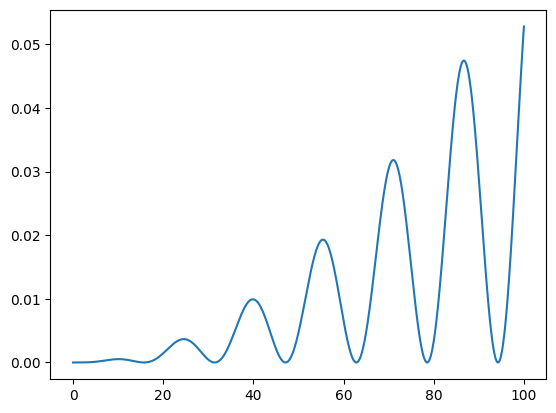

In [44]:
plt.figure()
plt.plot(r, pi)
plt.show()

In [34]:
p_det(H0, r)

0.06533333333333334

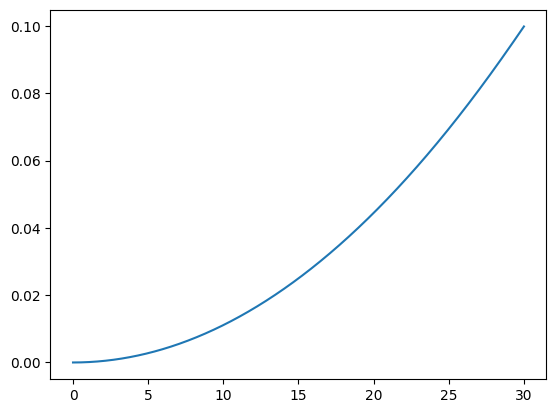

In [18]:
plt.figure()
plt.plot(r, y, )

plt.show()